In [1]:
!pip install torch-geometric


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 8.3 MB/s eta 0:00:00


In [2]:
import random
import time
#import open3d as o3d
import numpy as np
import gc
import os

import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch_geometric.data import DataLoader
from torch_geometric.nn import global_max_pool
from torch_geometric.nn import knn_interpolate


import torch
from torch.utils.data import Dataset
from torch_geometric.datasets import ModelNet
from torch_geometric.transforms import SamplePoints, NormalizeScale

from torch_geometric.data import Data
import torch_geometric.transforms as T

from google.colab import drive
from google.colab import files


from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from torch.utils.data import random_split


from mpl_toolkits.mplot3d.art3d import Poly3DCollection

from torch_geometric.nn import GlobalAttention, Linear
from torch.nn import Sequential, ReLU, Linear as Lin



In [3]:
drive.mount('/content/drive')
root_path = '/content/drive/My Drive/ADLG/Project_2/ModelNet10'

Mounted at /content/drive


In [16]:
your_desired_seed = 32  # Example seed
torch.manual_seed(your_desired_seed)
np.random.seed(your_desired_seed)
random.seed(your_desired_seed)


# Define the number of points you want to sample
num_points = 2048

# Create the transform
transform_point_cloud = SamplePoints(num_points)
pre_transform = T.NormalizeScale()


# Apply the transform to the datasets
train_dataset = ModelNet(root=root_path, name='10', train=True,
                         pre_transform=pre_transform,
                         transform=transform_point_cloud)

test_dataset = ModelNet(root=root_path, name='10', train=False,
                        pre_transform=pre_transform,
                        transform=transform_point_cloud)

print(train_dataset)


ModelNet10(3991)


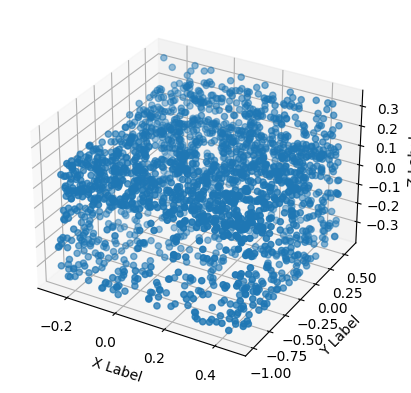

In [5]:

def visualize_point_cloud(point_cloud):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(point_cloud[:, 0], point_cloud[:, 1], point_cloud[:, 2])
    ax.set_xlabel('X Label')
    ax.set_ylabel('Y Label')
    ax.set_zlabel('Z Label')
    plt.show()

# Visualize the first sample in the train dataset
data = train_dataset[231]
point_cloud = data.pos
visualize_point_cloud(point_cloud.numpy())


In [ ]:


def visualize_modelnet_mesh(data):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    # Extract vertices and faces
    vertices = data.pos.numpy()
    faces = data.face.t().contiguous().numpy()

    # Create a collection of faces
    mesh = Poly3DCollection(vertices[faces])
    mesh.set_edgecolor('k')
    ax.add_collection3d(mesh)

    # Determine the axis limits
    x_max, y_max, z_max = vertices.max(axis=0)
    x_min, y_min, z_min = vertices.min(axis=0)
    max_range = np.array([x_max - x_min, y_max - y_min, z_max - z_min]).max() / 2.0
    mid_x = (x_max + x_min) / 2
    mid_y = (y_max + y_min) / 2
    mid_z = (z_max + z_min) / 2

    ax.set_xlim(mid_x - max_range, mid_x + max_range)
    ax.set_ylim(mid_y - max_range, mid_y + max_range)
    ax.set_zlim(mid_z - max_range, mid_z + max_range)

    # Set labels and title
    ax.set_xlabel('X axis')
    ax.set_ylabel('Y axis')
    ax.set_zlabel('Z axis')
    # ax.set_title('Mesh Visualization')

    plt.show()

# Visualize the first sample in the train dataset
sample = train_dataset[231]  # Adjust the index as needed
visualize_modelnet_mesh(sample)


In [17]:
from torch_geometric.loader import DataLoader

your_desired_seed = 32  # Example seed
torch.manual_seed(your_desired_seed)
np.random.seed(your_desired_seed)
random.seed(your_desired_seed)

def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

# Define your batch size
batch_size = 32

from torch.utils.data import random_split
val_size = int(0.2 * len(train_dataset))
train_size = len(train_dataset) - val_size

train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size, shuffle=True, num_workers=8, worker_init_fn=seed_worker)
val_loader = DataLoader(val_dataset, batch_size, shuffle=False, num_workers=8, worker_init_fn=seed_worker)
test_loader = DataLoader(test_dataset, batch_size, shuffle=False, num_workers=8, worker_init_fn=seed_worker)



#PointCloudGNN

In [18]:
class PointCloudGNN(torch.nn.Module):
    def __init__(self, num_classes):
        super(PointCloudGNN, self).__init__()

        # Define the layers
        self.lin1 = Lin(3, 16)
        self.lin2 = Lin(16, 32)

        # Global Attention Pooling layer
        gate_nn = Sequential(Linear(32, 32), ReLU(), Linear(32, 1))
        self.global_att_pool = GlobalAttention(gate_nn)

        # Output layer
        self.out = Lin(32, num_classes)

    def forward(self, data):
        x = data.pos  # Extract node features (position coordinates)

        # Apply linear transformations
        x = self.lin1(x)
        x = torch.relu(x)
        x = self.lin2(x)
        x = torch.relu(x)

        # Apply global attention pooling
        x = self.global_att_pool(x, data.batch)

        # Apply output layer
        x = self.out(x)

        # Softmax here not needed, as I use the crossentropy loss, which combines a softmax operation and a NLL
        x = F.log_softmax(x, dim=1)

        return x



In [22]:
def train_and_validate(model, train_loader, val_loader, criterion, optimizer, num_epochs=3, patience=3):
    best_val_loss = np.inf
    epochs_no_improve = 0
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


    for epoch in range(num_epochs):
        # Training phase
        model.train()
        total_loss = 0
        for data in train_loader:
            data.pos = data.pos.to(device)
            data.y = data.y.to(device)

            optimizer.zero_grad()
            # output, _, _ = model(data)  # Adapt to model's output format PointNet
            output = model(data)  # Pass the whole data object to the model PointCloud
            loss = criterion(output, data.y)  # data.y contains the labels
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        avg_train_loss = total_loss / len(train_loader)

        # Validation phase
        model.eval()
        total_val_loss = 0
        with torch.no_grad():
            for data in val_loader:
                data = data.to(device)
                output = model(data)
                #output, _, _ = model(data)  # Adapt to model's output format PointNet

                loss = criterion(output, data.y)
                total_val_loss += loss.item()

        avg_val_loss = total_val_loss / len(val_loader)
        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

        # Early stopping check
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            if epochs_no_improve == patience:
                print("Early stopping triggered")
                break


num_classes = 10
model = PointCloudGNN(num_classes)

# criterion = torch.nn.CrossEntropyLoss()
criterion = torch.nn.NLLLoss()

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
num_epochs = 3
patience = 3

train_and_validate(model, train_loader, val_loader, criterion, optimizer, num_epochs=num_epochs, patience=patience)




Epoch 1/3, Train Loss: 2.2318, Val Loss: 2.1337
Epoch 2/3, Train Loss: 2.0824, Val Loss: 1.9415
Epoch 3/3, Train Loss: 1.7282, Val Loss: 1.4545


The "GNN-like" part of the PointCloudGNN class primarily lies in the usage of the Global Attention Pooling layer. Key concept of Graph Neural Networks: the aggregation of node features based on their relative importance or relevance, which is a fundamental aspect of GNNs.

Feature Transformation:
Before reaching the Global Attention Pooling layer, each node's features (3D coordinates) are transformed through linear layers. These transformations (done by self.lin1 and self.lin2) map the original 3D coordinates into a higher-dimensional feature space, where complex relationships and patterns might be more easily captured.

Computing Attention Coefficients:
The Global Attention Pooling layer uses a small neural network (gate_nn in the example) to compute attention coefficients for each node.
This network takes the transformed features of each node as input and outputs a scalar value for each node, representing the attention coefficient.
The attention coefficients determine the importance or relevance of each node's features in the context of the entire point cloud.

Aggregating Node Features:
These coefficients are then used to create a weighted sum of the node features. Nodes with higher attention coefficients contribute more to the final aggregated feature vector.
This process effectively allows the model to "pay more attention" to certain nodes (points) that are more significant for the task at hand, such as points that define critical shapes or structures in the point cloud.

Resulting Global Feature Representation:
The output of the Global Attention Pooling layer is a single feature vector that represents the entire point cloud. This vector captures the essence of the point cloud as determined by the learned attention coefficients.
This global feature vector is then passed through the final output layer (in your model, self.out) to make a prediction or classification.

In point cloud processing, not all points are equally informative for understanding the overall structure or for making decisions. Global Attention Pooling allows the model to focus on the most informative points while downplaying less relevant ones.

This approach is particularly useful when dealing with varying sizes and densities of point clouds, as it provides a flexible way to summarize the entire cloud into a fixed-size representation, which is crucial for tasks like classification or segmentation.

Test Loss: 1.4021, Test Accuracy: 0.5055


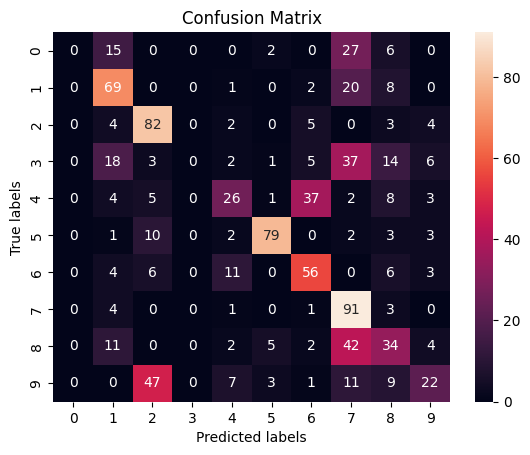

In [ ]:

def evaluate_on_test(model, test_loader, criterion):
    model.eval()  # Set the model to evaluation mode
    total_loss = 0
    all_predictions = []
    all_targets = []

    with torch.no_grad():
        for data in test_loader:
            data = data.to(device)
            output = model(data)
            loss = criterion(output, data.y)
            total_loss += loss.item()

            _, predictions = torch.max(output, 1)
            all_predictions.extend(predictions.cpu().numpy())
            all_targets.extend(data.y.cpu().numpy())

    avg_loss = total_loss / len(test_loader)
    accuracy = (np.array(all_predictions) == np.array(all_targets)).mean()
    print(f"Test Loss: {avg_loss:.4f}, Test Accuracy: {accuracy:.4f}")
    return all_predictions, all_targets

# Evaluate the model and get predictions and true labels
predictions, targets = evaluate_on_test(model, test_loader, criterion)

# Create the confusion matrix
cm = confusion_matrix(targets, predictions)
sns.heatmap(cm, annot=True, fmt='g')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()


#PointNet

In [9]:
#%%writefile pointnet_model.py
%cd /content/drive/My Drive/ADLG/Project_2

# from pointnet_model0 import PointNetCls
from pointnet_model import PointNetCls

num_classes = 10  # Example: Change this to the number of classes in your dataset
model = PointNetCls(num_classes, feature_transform=False)

# model = PointCloudGNN(num_classes)


/content/drive/My Drive/ADLG/Project_2


In [10]:
def preprocess_data_for_pointnet(data_batch, num_points=512):
    all_pos = data_batch.pos
    all_batches = data_batch.batch
    batch_size = data_batch.y.size(0)

    reshaped_data = []
    for i in range(batch_size):
        mask = (all_batches == i)
        single_cloud = all_pos[mask]

        # Sample or pad points to ensure consistent num_points
        if single_cloud.size(0) < num_points:
            # Padding
            padding = torch.zeros(num_points - single_cloud.size(0), 3)
            single_cloud = torch.cat([single_cloud, padding], dim=0)
        elif single_cloud.size(0) > num_points:
            # Sampling
            indices = torch.randperm(single_cloud.size(0))[:num_points]
            single_cloud = single_cloud[indices]

        reshaped_data.append(single_cloud.unsqueeze(0))

    # Reshape to [batch_size, num_features, num_points]
    return torch.cat(reshaped_data, dim=0).transpose(1, 2), data_batch.y


In [11]:
def train_and_validate(model, train_loader, val_loader, criterion, optimizer, num_epochs=3, patience=3, num_points=2048):
    best_val_loss = np.inf
    epochs_no_improve = 0

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        total_loss = 0
        for data in train_loader:
            inputs, labels = preprocess_data_for_pointnet(data, num_points=num_points)
            inputs, labels = inputs.to(device), labels.squeeze().to(device)


            optimizer.zero_grad()
            outputs, _, _ = model(inputs)  # Extract only the logits
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        avg_train_loss = total_loss / len(train_loader)

        # Validation phase
        model.eval()
        total_val_loss = 0
        with torch.no_grad():
            for data in val_loader:
                inputs, labels = preprocess_data_for_pointnet(data, num_points=num_points)

                outputs, _, _ = model(inputs)  # Extract only the logits
                loss = criterion(outputs, labels)
                total_val_loss += loss.item()

        avg_val_loss = total_val_loss / len(val_loader)
        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

        # Early stopping check
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            if epochs_no_improve == patience:
                print("Early stopping triggered")
                break


In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

num_classes = 10
model = PointNetCls(num_classes, feature_transform=False)

# Criterion and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Device Setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Training Parameters
num_epochs = 3
patience = 3
num_points = 2048  # If your PointNet model expects a fixed number of points

# Training and Validation
train_and_validate(model, train_loader, val_loader, criterion, optimizer, num_epochs=num_epochs, patience=patience, num_points=num_points)


Epoch 1/3, Train Loss: 0.8720, Val Loss: 0.9618
Epoch 2/3, Train Loss: 0.4849, Val Loss: 0.5093
Epoch 3/3, Train Loss: 0.3678, Val Loss: 0.3255


In [13]:
def evaluate(model, test_loader, criterion, num_points):
    model.eval()
    total_loss = 0
    correct_predictions = 0
    total_predictions = 0

    with torch.no_grad():
       #for inputs, labels in test_loader:
       for data in test_loader:
            inputs, labels = preprocess_data_for_pointnet(data, num_points=num_points)
            #inputs, labels = inputs.to(device), labels.squeeze().to(device)


            outputs, _, _ = model(inputs)
            loss = criterion(outputs, labels)
            total_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            correct_predictions += (predicted == labels).sum().item()
            total_predictions += labels.size(0)

    avg_loss = total_loss / len(test_loader)
    accuracy = correct_predictions / total_predictions
    return avg_loss, accuracy

# Usage
test_loss, test_accuracy = evaluate(model, test_loader, criterion, num_points=num_points)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")


Test Loss: 0.4840, Test Accuracy: 0.8282
